# Evaluation Usage Example

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
from vtt.data.caption_preprocessing import load_tokenizer, load_and_clean_captions
from vtt.data.data_loader import load_split_datasets
from vtt.models.decoder import build_decoder_model
from vtt.evaluation.evaluate import evaluate_model_beam, evaluate_model_greedy
from vtt.evaluation.evaluate import evaluate_captions
from vtt.models.predict import display_images_with_greedy_captions, display_images_with_beam_captions

/opt/anaconda3/envs/genai_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Sample

In [97]:
ground_truths = {
    "image1.jpg": ["a man riding a bike", "a person on a bicycle in motion"],
    "image2.jpg": ["a cat sitting on a couch", "a feline on furniture"],
}

generated = {
    "image1.jpg": "a man riding a bicycle",
    "image2.jpg": "a cat is lying on a sofa",
}

scores = evaluate_captions(ground_truths, generated)
for metric, value in scores.items():
    print(f"{metric}: {value:.4f}")

/opt/miniconda3/envs/genai_project/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BLEU-1: 0.7857
BLEU-2: 0.7182
BLEU-3: 0.5169
BLEU-4: 0.4293
METEOR: 0.7936
BERTScore_P: 0.9723
BERTScore_R: 0.9735
BERTScore_F1: 0.9729


## Caption Prediction on Test Set

### Fetch the Test dataset for evaluation

In [98]:
dataset_name = "flickr8k"
features_path = f"../data/processed/{dataset_name}_features.npz"
captions_path = f"../data/processed/{dataset_name}_padded_caption_sequences.npz"
tokenizer_path = f"../data/processed/{dataset_name}_tokenizer.json"

tokenizer = load_tokenizer(tokenizer_path)
features = np.load(features_path)

train_ds, val_ds, test_ds = load_split_datasets(
    features_path=features_path,
    captions_path=captions_path,
    batch_size=64,
    val_split=0.15,
    test_split=0.10,
    shuffle=True,
    buffer_size=1000,
    seed=42,
    cache=True,
    return_numpy=False
)

[INFO] Tokenizer loaded from JSON file: ../data/processed/flickr8k_tokenizer.json

--- Dataset Split Sizes (number of individual samples) ---
Total samples loaded: 38008
Train samples: 28507
Validation samples: 5701
Test samples: 3800
----------------------------------------------------------



### Fetch Max caption size and vocabulary size

In [ ]:

# Get max caption length from dataset
for (image_tensor, input_caption), _, _ in train_ds.take(1):
    max_caption_len = input_caption.shape[1]
# Get vocab size
vocab_size = tokenizer.num_words

2025-07-18 22:20:37.701648: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Load the Saved Model Weights

In [101]:
model = build_decoder_model(vocab_size=vocab_size,
                            max_caption_len=max_caption_len)

checkpoint_path = "../models/flickr8k_decoder_weights.weights.h5"
model.load_weights(checkpoint_path)
print("Loaded pretrained weights")

Loaded pretrained weights


/opt/miniconda3/envs/genai_project/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Optional: Enable Batch Processing (Faster on GPU)

Caption generation is performed sequentially on CPU, which is simpler and ensures compatibility across devices.

When on a machine with a GPU and sufficient memory, one can optionally switch to batch processing for faster evaluation.

To enable it:
- Uncomment the code block below.

In [ ]:
'''
# Rebatch test dataset into larger or smaller batches, depending on your system memory
# larger batches for faster inference (as long as you have enough memory)
new_batch_size = 128
batched_test_ds_for_eval = test_ds.unbatch().batch(new_batch_size).prefetch(tf.data.AUTOTUNE)

# Load captions into references dict
references_dict = load_and_clean_captions(f"../data/raw/{dataset_name}_captions.csv")

scores = evaluate_model_greedy(
    model=model,
    tokenizer=tokenizer,
    features=features,
    test_dataset=test_ds,
    references_dict=references_dict,
    max_len=max_caption_len,
)

print("Evaluation Scores:")
for metric, score in scores.items():
    print(f"{metric}: {score:.4f}")

    '''

### Evaluate Scores for Test Dataset using Greedy Caption Generation - Sequential

In [ ]:
references_dict = load_and_clean_captions(f"../data/raw/{dataset_name}_captions.csv")

scores_greedy = evaluate_model_greedy(
    model=model,
    tokenizer=tokenizer,
    features=features,
    test_dataset=test_ds,
    references_dict=references_dict,
    max_len=max_caption_len,
)

Generating Captions from Dataset: 100%|██████████| 60/60 [24:35<00:00, 24.58s/it]
/opt/miniconda3/envs/genai_project/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
W0717 21:54:37.248000 45285 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### BLEU, METEOR and BertScore for Greedy Caption generation

In [ ]:
print("Evaluation Scores:")
for metric, score in scores_greedy.items():
    print(f"{metric}: {score:.4f}")

Evaluation Scores:
BLEU-1: 0.4705
BLEU-2: 0.2836
BLEU-3: 0.1710
BLEU-4: 0.1126
METEOR: 0.2661
BERTScore_P: 0.8854
BERTScore_R: 0.8552
BERTScore_F1: 0.8699


### Evaluate Scores for Test Dataset using Beam Search - Sequential

In [ ]:
scores_beam = evaluate_model_beam(
    model=model,
    tokenizer=tokenizer,
    features=features,
    test_dataset=test_ds,
    references_dict=references_dict,
    max_len=max_caption_len,
    beam_width=5
)

Evaluating: 100%|██████████| 60/60 [2:03:19<00:00, 123.33s/it]  
/opt/miniconda3/envs/genai_project/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### BLEU, METEOR and BertScore for Caption generation using Beam Search

In [88]:
print("Evaluation Scores:")
for metric, score in scores_beam.items():
    print(f"{metric}: {score:.4f}")

Evaluation Scores:
BLEU-1: 0.4712
BLEU-2: 0.2865
BLEU-3: 0.1778
BLEU-4: 0.1199
METEOR: 0.2675
BERTScore_P: 0.8906
BERTScore_R: 0.8552
BERTScore_F1: 0.8725


## Predict Sample Captions from Test Set

In [ ]:
import random

# Step 1: Unbatch and collect all image IDs from test_ds
all_image_ids = [img_id.numpy().decode('utf-8') for (_, _,),_, img_id in test_ds.unbatch()]

# Step 2: Sample 5 random IDs
sample_image_ids = random.sample(all_image_ids, 10)


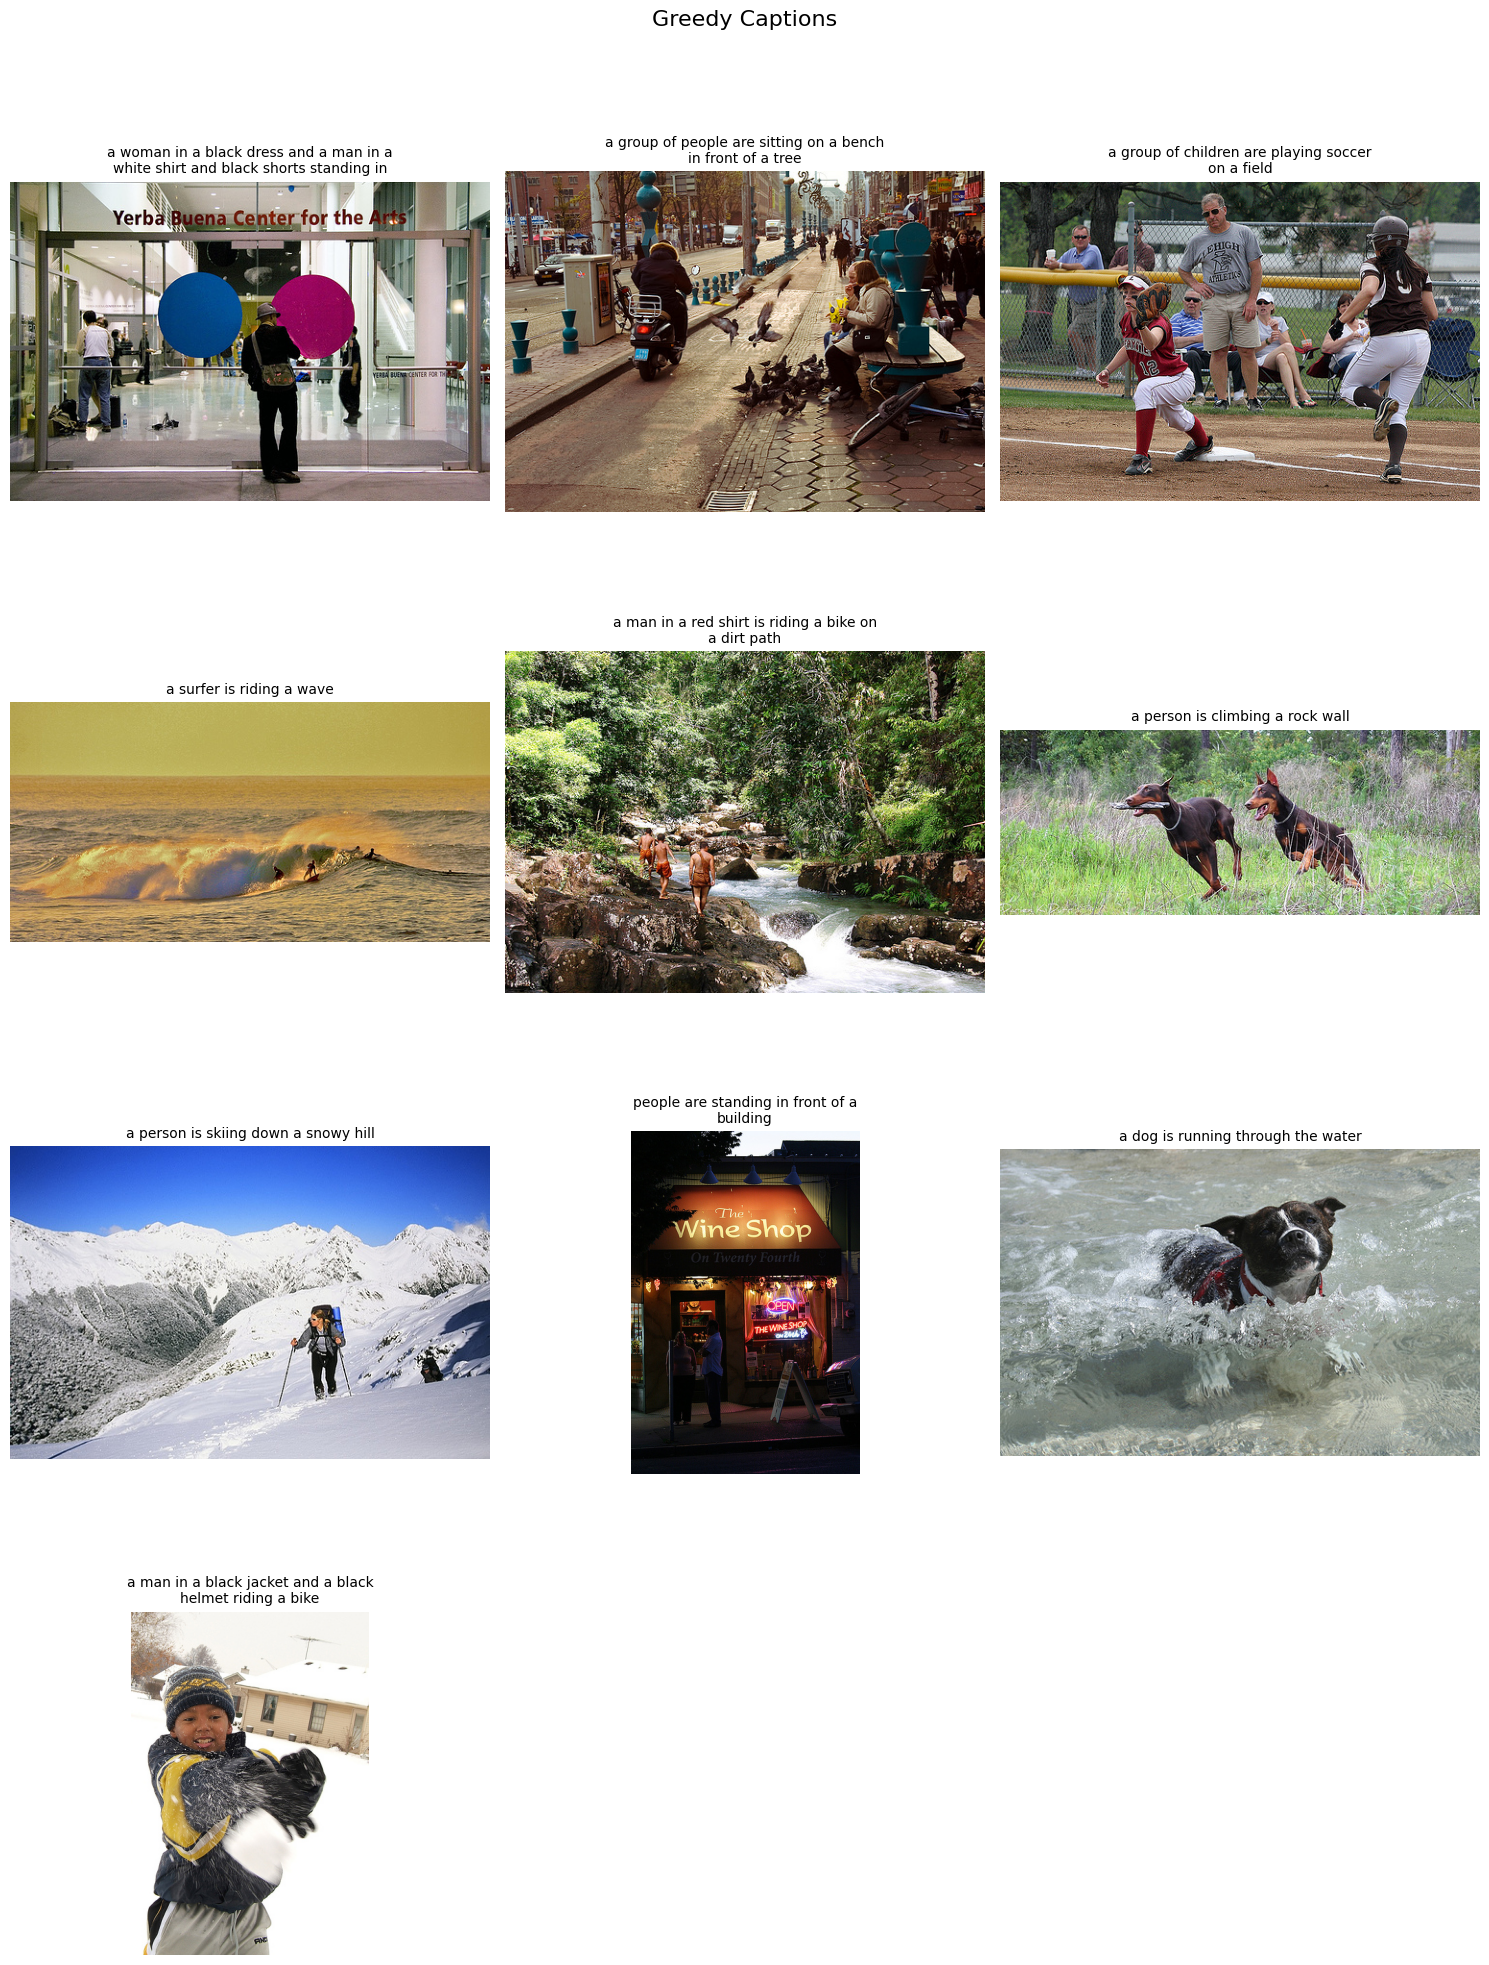

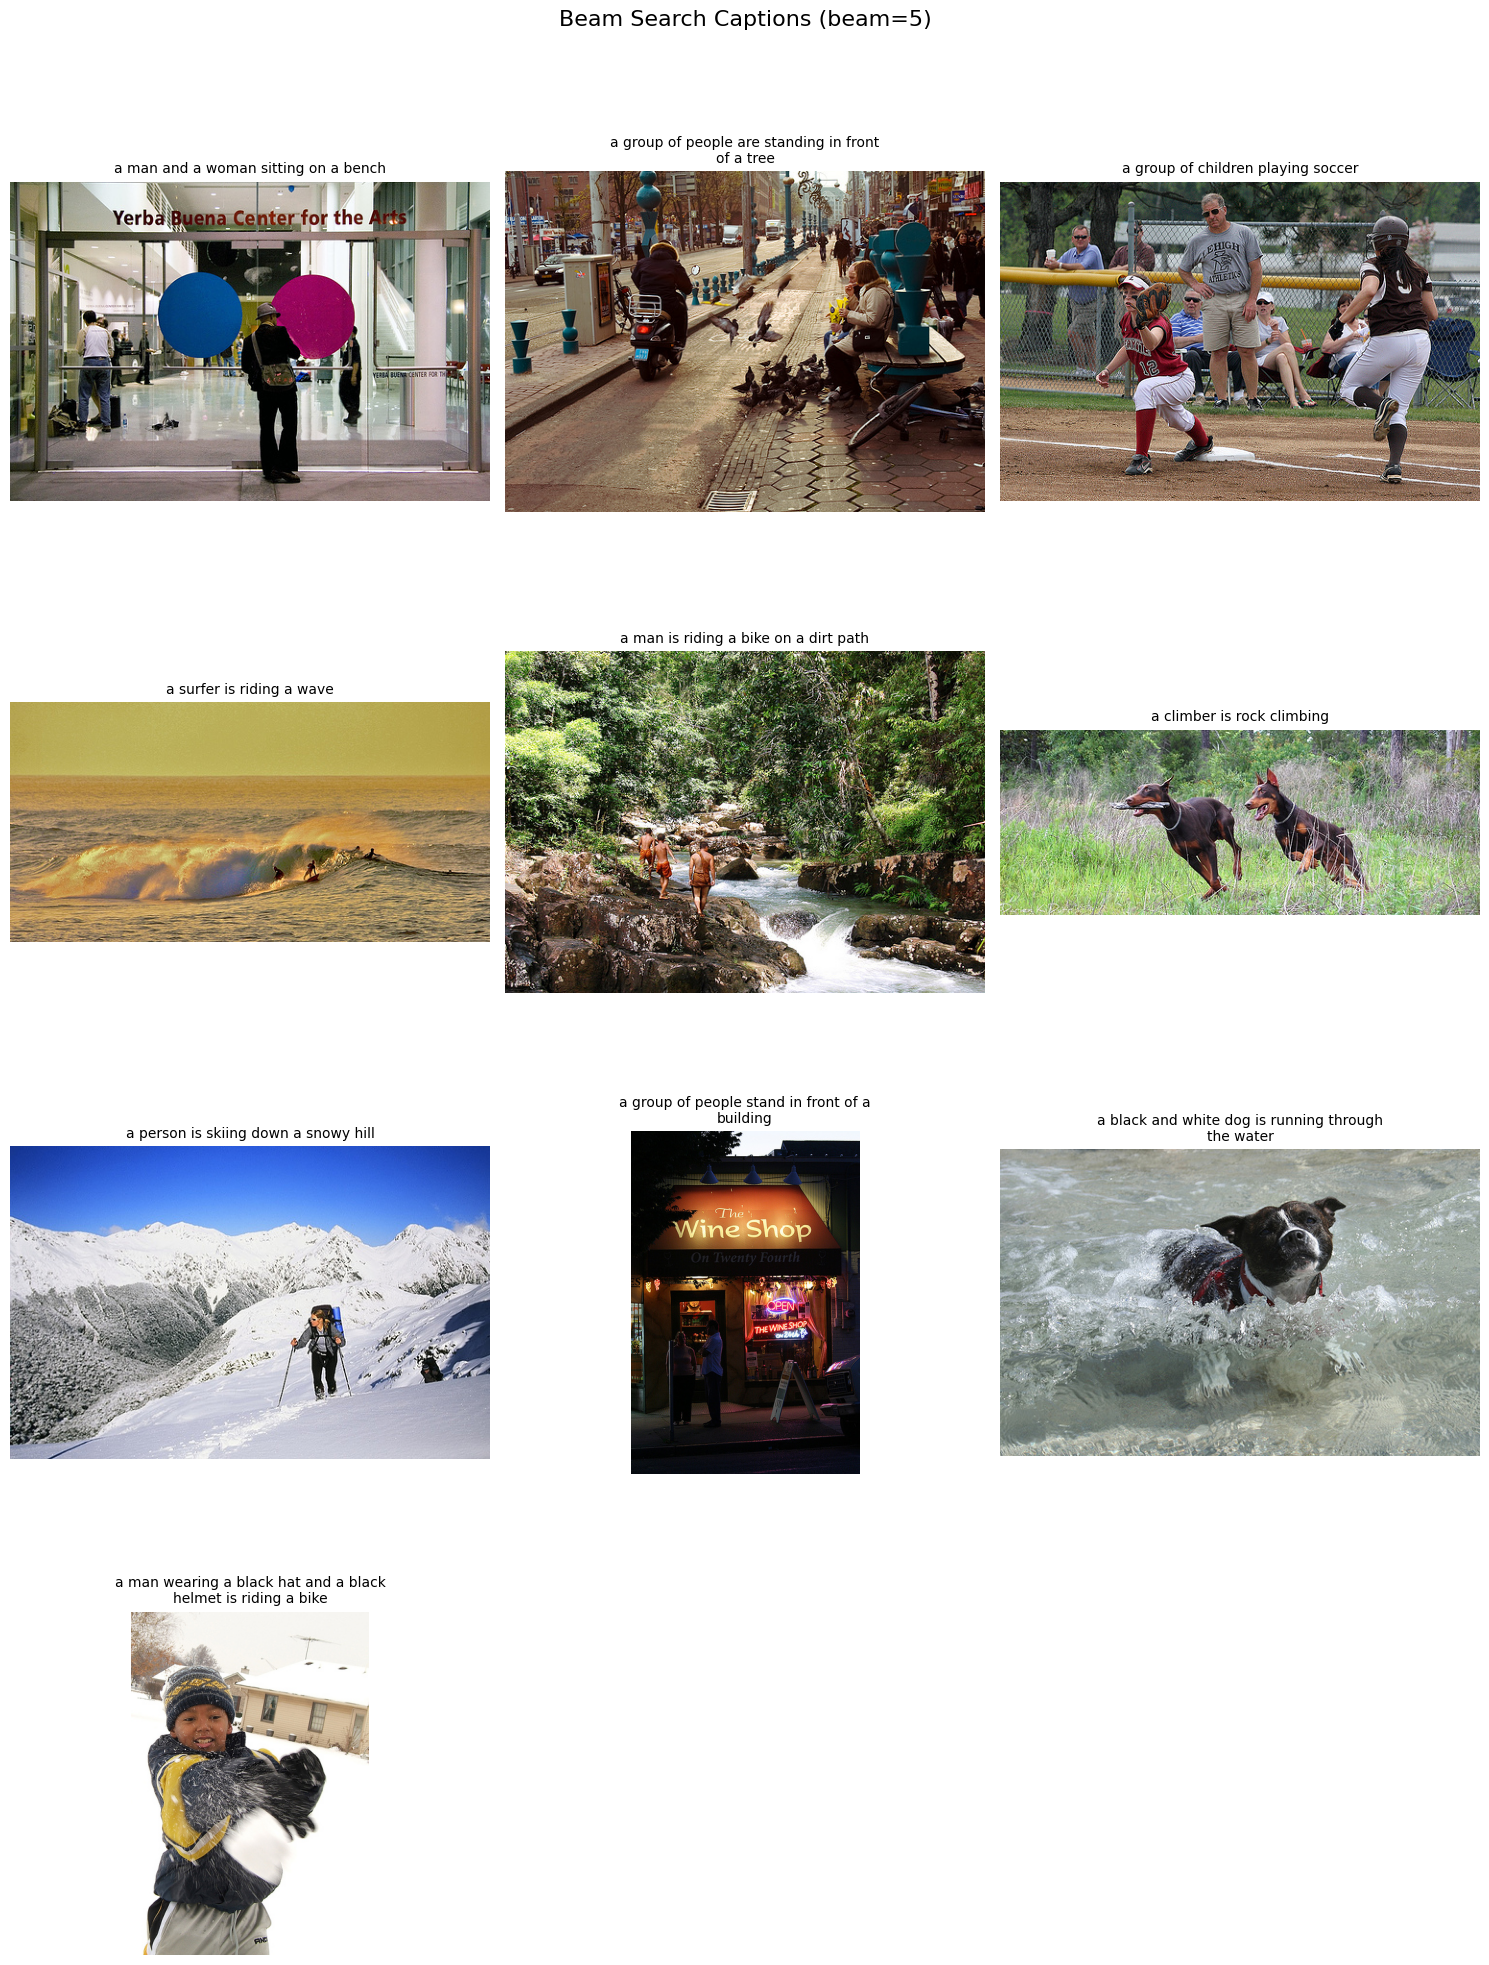

In [ ]:
image_folder = "../data/flickr8k_images_dataset/Images"

# Step 3: Call display_images_with_captions
display_images_with_greedy_captions(
    image_ids=sample_image_ids,
    model=model,
    tokenizer=tokenizer,
    features=features,
    image_folder=image_folder
)

display_images_with_beam_captions(
    image_ids=sample_image_ids,
    model=model,
    tokenizer=tokenizer,
    features=features,
    image_folder=image_folder,
    beam_width=5,
    max_len=max_caption_len,
    cols=3,
)
